# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
import plotly
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# посмотрим, какие значения есть в столбце job

df.job.unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# посмотрим, как выглядят значения колонки balance
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [6]:
# нам нужно заменить запятые на точки и убрать знак валюты и пробелы

df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].str.replace(',', '.')
df['balance'] = df['balance'].str.replace(' ', '')
# поменяем тип данных
df['balance'] = df['balance'].astype(float)

df.balance.info()

<class 'pandas.core.series.Series'>
RangeIndex: 11162 entries, 0 to 11161
Series name: balance
Non-Null Count  Dtype  
--------------  -----  
11137 non-null  float64
dtypes: float64(1)
memory usage: 87.3 KB


In [7]:
# Вычислим среднее значение по признаку balance

print(round(df.balance.mean(), 3))

1529.129


### Задание 4

In [8]:
# обработайте пропуски в признаке balance , заменив их на медианные значения по данному признаку

df['balance'].fillna(df['balance'].median(), inplace=True)

# Вычислим среднее значение по признаку balance
print(round(df.balance.mean(), 3))

1526.936


### Задание 5

In [9]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

# посмотрим, какие значения есть в наших столбцах и какие самые популярные значения в них
print(df.job.unique())
print(df.job.mode())

print(df.education.unique())
print(df.education.mode())

['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
0    management
Name: job, dtype: object
['secondary' 'tertiary' 'primary' 'unknown']
0    secondary
Name: education, dtype: object


In [10]:
# заменим пропущенные значения на самые популярные
df.loc[df['job'] == 'unknown', 'job'] = 'management'
df.loc[df['education'] == 'unknown', 'education'] = 'secondary'

In [11]:
# рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования.
mask = (df['job'] == 'management') & (df['education'] == 'secondary')

print(round(df.loc[mask, 'balance'].mean(),3))

1598.883


### Задание 6

In [12]:
# удалите все выбросы для признака balance

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Нижняя граница: {round(lower_bound)}')
print(f'Нижняя граница: {round(upper_bound)}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Нижняя граница: -2241
Нижняя граница: 4063
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [13]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

cleaned.deposit.value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

In [14]:
deposit_data = cleaned.groupby(
    by='deposit', as_index=False
    )[['deposit']].count()

fig = px.bar(
    data_frame=deposit_data,
    y='deposit',
    color='deposit',
    height=800,
    width=800,
    title='Распределение признака deposit',
    color_continuous_scale=px.colors.diverging.Tropic
)

fig.show()

### Задания 2 и 3

In [15]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [16]:
# посмотрим распределение баланса клиентов в зависимости от возраста

fig = px.scatter(
    cleaned, 
    y='age', 
    x='balance', 
    color='age',
    height=1000,
    width=1000,
    title='Взаимосвязь баланса и возраста клиентов',
    color_continuous_scale=px.colors.diverging.Tealrose
    )

fig.show()

### Задания 4 и 5

In [17]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат

cleaned.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


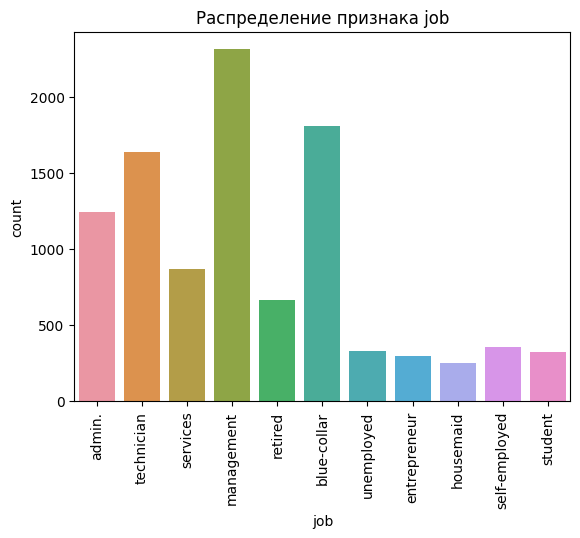

In [18]:
sns.set
sns.countplot(
    x=cleaned.job
    ).set(title='Распределение признака job')

plt.xticks(rotation=90);

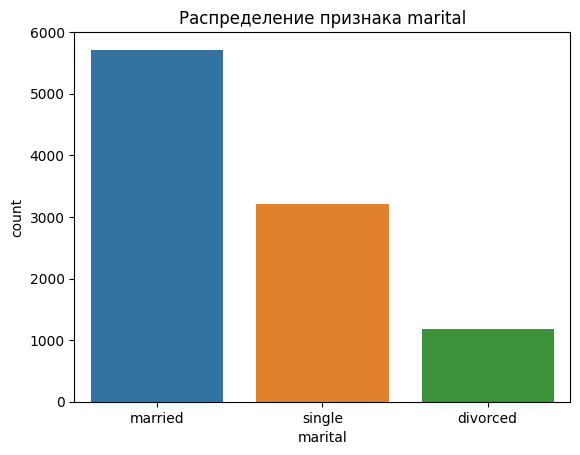

In [19]:
sns.set
sns.countplot(
    x=cleaned.marital
    ).set(title='Распределение признака marital');

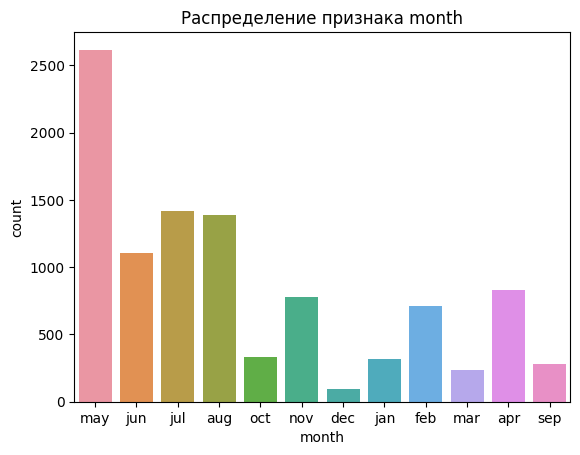

In [20]:
sns.set
sns.countplot(
    x=cleaned.month
    ).set(title='Распределение признака month');

### Задание 6

In [21]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

poutcome_data = cleaned.groupby(
    by='poutcome', as_index=False
    )[['deposit']].value_counts()
poutcome_data

,poutcome,deposit,count
0,failure,no,562
1,failure,yes,547
2,other,yes,265
3,other,no,216
4,success,yes,861
5,success,no,84
6,unknown,no,4562
7,unknown,yes,3008


In [22]:
fig = px.bar(
    data_frame=poutcome_data,
    x='poutcome',
    y='count',
    color='deposit',
    height=800,
    width=900,
    title='Соотношение удачных маркетинговых компаний к неудачным в зависимости от статуса',
    color_continuous_scale=px.colors.diverging.Tropic
)

fig.show()

### Задание 7

In [23]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

month_list = cleaned.month.unique().tolist()

for month in month_list:
    month_mask = cleaned.month == month
    no_deposit_mask = month_mask & (cleaned.deposit == 'no')
    failure_rate = cleaned.loc[no_deposit_mask].month.count() / cleaned.loc[month_mask].month.count() * 100
    print(f'В месяце {month} процент отказов составил {round(failure_rate, 2)}')

В месяце may процент отказов составил 67.86
В месяце jun процент отказов составил 54.89
В месяце jul процент отказов составил 58.96
В месяце aug процент отказов составил 55.96
В месяце oct процент отказов составил 18.51
В месяце nov процент отказов составил 58.46
В месяце dec процент отказов составил 9.68
В месяце jan процент отказов составил 60.82
В месяце feb процент отказов составил 45.56
В месяце mar процент отказов составил 10.13
В месяце apr процент отказов составил 38.19
В месяце sep процент отказов составил 16.55


### Задание 8

In [24]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

# зададим функцию для определения принадлежности к каждой возрастной группе
def get_age(age):
    age_category = 0
    if age < 30:
        age_category = '< 30'
    if 30 <= age < 40:
        age_category = '30 < 40'
    if 40 <= age < 50:
        age_category = '40 < 50'
    if 50 <= age < 60:
        age_category = '50 < 60'
    if age >= 60:
        age_category = ' > 60'
    return age_category

# вызовем функцию
cleaned['age_category'] = cleaned['age'].apply(get_age)

# посмотрим на результат
cleaned.age_category.value_counts()

30 < 40    3961
40 < 50    2382
50 < 60    1654
< 30       1455
 > 60       653
Name: age_category, dtype: int64

In [25]:
grouped_by_age = cleaned.groupby(['age_category','deposit'])[['deposit']].count()
grouped_by_age.columns = ['Clients']
grouped_by_age = grouped_by_age.reset_index()
grouped_by_age

,age_category,deposit,Clients
0,> 60,no,157
1,> 60,yes,496
2,30 < 40,no,2245
3,30 < 40,yes,1716
4,40 < 50,no,1444
5,40 < 50,yes,938
6,50 < 60,no,984
7,50 < 60,yes,670
8,< 30,no,594
9,< 30,yes,861


In [26]:
fig = px.bar(
    data_frame=grouped_by_age,
    x='age_category',
    y='Clients',
    orientation='v',
    height=700,
    width=700,
    color='deposit',
    title='Зависимость склонности открывать депозит от возраста'
)

fig.show()

### Задания 9 и 10

In [27]:
cleaned.job.value_counts()

management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

In [28]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

grouped_by_marital = cleaned.groupby(['marital','deposit'])[['deposit']].count()
grouped_by_marital.columns = ['Clients']
grouped_by_marital = grouped_by_marital.reset_index()

fig = px.bar(
    data_frame=grouped_by_marital,
    x='marital',
    y='Clients',
    orientation='v',
    height=700,
    width=700,
    color='deposit',
    title='Зависимость склонности открывать депозит от семейного положения'
)

fig.show()

In [29]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

grouped_by_education = cleaned.groupby(['education','deposit'])[['deposit']].count()
grouped_by_education.columns = ['Clients']
grouped_by_education = grouped_by_education.reset_index()

fig = px.bar(
    data_frame=grouped_by_education,
    x='education',
    y='Clients',
    orientation='v',
    height=700,
    width=700,
    color='deposit',
    title='Зависимость склонности открывать депозит от образования'
)

fig.show()

In [30]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

grouped_by_job = cleaned.groupby(['job','deposit'])[['deposit']].count()
grouped_by_job.columns = ['Clients']
grouped_by_job = grouped_by_job.reset_index()

fig = px.bar(
    data_frame=grouped_by_job,
    x='job',
    y='Clients',
    orientation='v',
    height=700,
    width=700,
    color='deposit',
    title='Зависимость склонности открывать депозит от профессии'
)

fig.show()

### Задание 11

In [31]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

no_deposit_clients = cleaned[cleaned['deposit'] == 'no']
yes_deposit_clients = cleaned[cleaned['deposit'] == 'yes']

grouped_no_deposit = no_deposit_clients.groupby(['education','marital'])[['deposit']].count()
grouped_no_deposit.columns = ['clients']
grouped_no_deposit = grouped_no_deposit.reset_index()


grouped_yes_deposit = yes_deposit_clients.groupby(['education','marital'])[['deposit']].count()
grouped_yes_deposit.columns = ['clients']
grouped_yes_deposit = grouped_yes_deposit.reset_index()

In [32]:
grouped_no_deposit

,education,marital,clients
0,primary,divorced,91
1,primary,married,641
2,primary,single,100
3,secondary,divorced,370
4,secondary,married,1830
5,secondary,single,866
6,tertiary,divorced,163
7,tertiary,married,832
8,tertiary,single,531


In [33]:
grouped_no_deposit_pivot = grouped_no_deposit.pivot_table(
    index='education',
    columns = 'marital',
    values='clients'
)

display(grouped_no_deposit_pivot)

fig = px.imshow(
    grouped_no_deposit_pivot,
    text_auto=True,
    title='Связь между уровнем образования и семейным статусом среди клиентов, не открывших депозит'
)

fig.update_layout(
    title_font_size=15
)

fig.layout.height = 500
fig.layout.width = 900
fig.show()

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


In [34]:
grouped_yes_deposit_pivot = grouped_yes_deposit.pivot_table(
    index='education',
    columns = 'marital',
    values='clients'
)

display(grouped_yes_deposit_pivot)

fig = px.imshow(
    grouped_yes_deposit_pivot,
    text_auto=True,
    title='Связь между уровнем образования и семейным статусом среди клиентов, открывших депозит'
)

fig.update_layout(
    title_font_size=15
)

fig.layout.height = 500
fig.layout.width = 900
fig.show()

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


## Часть 3: преобразование данных

### Задание 1

In [35]:
# преобразуйте уровни образования

label_encoder = preprocessing.LabelEncoder()
cleaned['education'] = label_encoder.fit_transform(cleaned['education'])

# Найдите сумму получившихся значений для признака education

cleaned.education.sum()

11995

In [36]:
# Обработайте порядковую переменную для возраста по такому же принципу

cleaned['age_category'] = label_encoder.fit_transform(cleaned['age_category'])

cleaned

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_category
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,3
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,3
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,2
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,3
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,1
11158,39,services,married,1,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,1
11159,32,technician,single,1,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,1
11160,43,technician,married,1,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,2


### Задания 2 и 3

In [37]:
# преобразуйте бинарные переменные в представление из нулей и единиц

cleaned['deposit'] = cleaned['deposit'].apply(lambda x: 0 if x == 'no' else 1)

round(cleaned.std(), 3)

age              11.735
education         0.647
balance         994.152
day               8.442
duration        346.652
campaign          2.707
pdays           109.644
previous          2.244
deposit           0.499
age_category      1.177
dtype: float64

In [38]:
# Сделаем то же самое для других бинарных переменных, которых у нас три:
binary_variables = ['default', 'housing', 'loan']

for var in binary_variables:
    cleaned[var] = cleaned[var].apply(lambda x: 0 if x == 'no' else 1)
    
cleaned

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_category
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,3
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,3
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,2
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,3
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,0,1.0,1,0,cellular,20,apr,257,1,-1,0,unknown,0,1
11158,39,services,married,1,0,733.0,0,0,unknown,16,jun,83,4,-1,0,unknown,0,1
11159,32,technician,single,1,0,29.0,0,0,cellular,19,aug,156,2,-1,0,unknown,0,1
11160,43,technician,married,1,0,0.0,0,1,cellular,8,may,9,2,172,5,failure,0,2


In [39]:
# Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата
# и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя

print(round(cleaned.default.mean() + cleaned.housing.mean() + cleaned.loan.mean(), 3))

0.635


### Задание 4

In [40]:
cleaned

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_category
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,3
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,3
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,2
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,3
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,0,1.0,1,0,cellular,20,apr,257,1,-1,0,unknown,0,1
11158,39,services,married,1,0,733.0,0,0,unknown,16,jun,83,4,-1,0,unknown,0,1
11159,32,technician,single,1,0,29.0,0,0,cellular,19,aug,156,2,-1,0,unknown,0,1
11160,43,technician,married,1,0,0.0,0,1,cellular,8,may,9,2,172,5,failure,0,2


In [41]:
# создайте дамми-переменные
columns_for_get_dummies = ['job', 'marital', 'contact', 'month', 'poutcome']
data_dummies = pd.get_dummies(cleaned[columns_for_get_dummies])
df = pd.concat([cleaned,data_dummies], axis = 1)
df.shape

(10105, 51)

### Задания 5 и 6

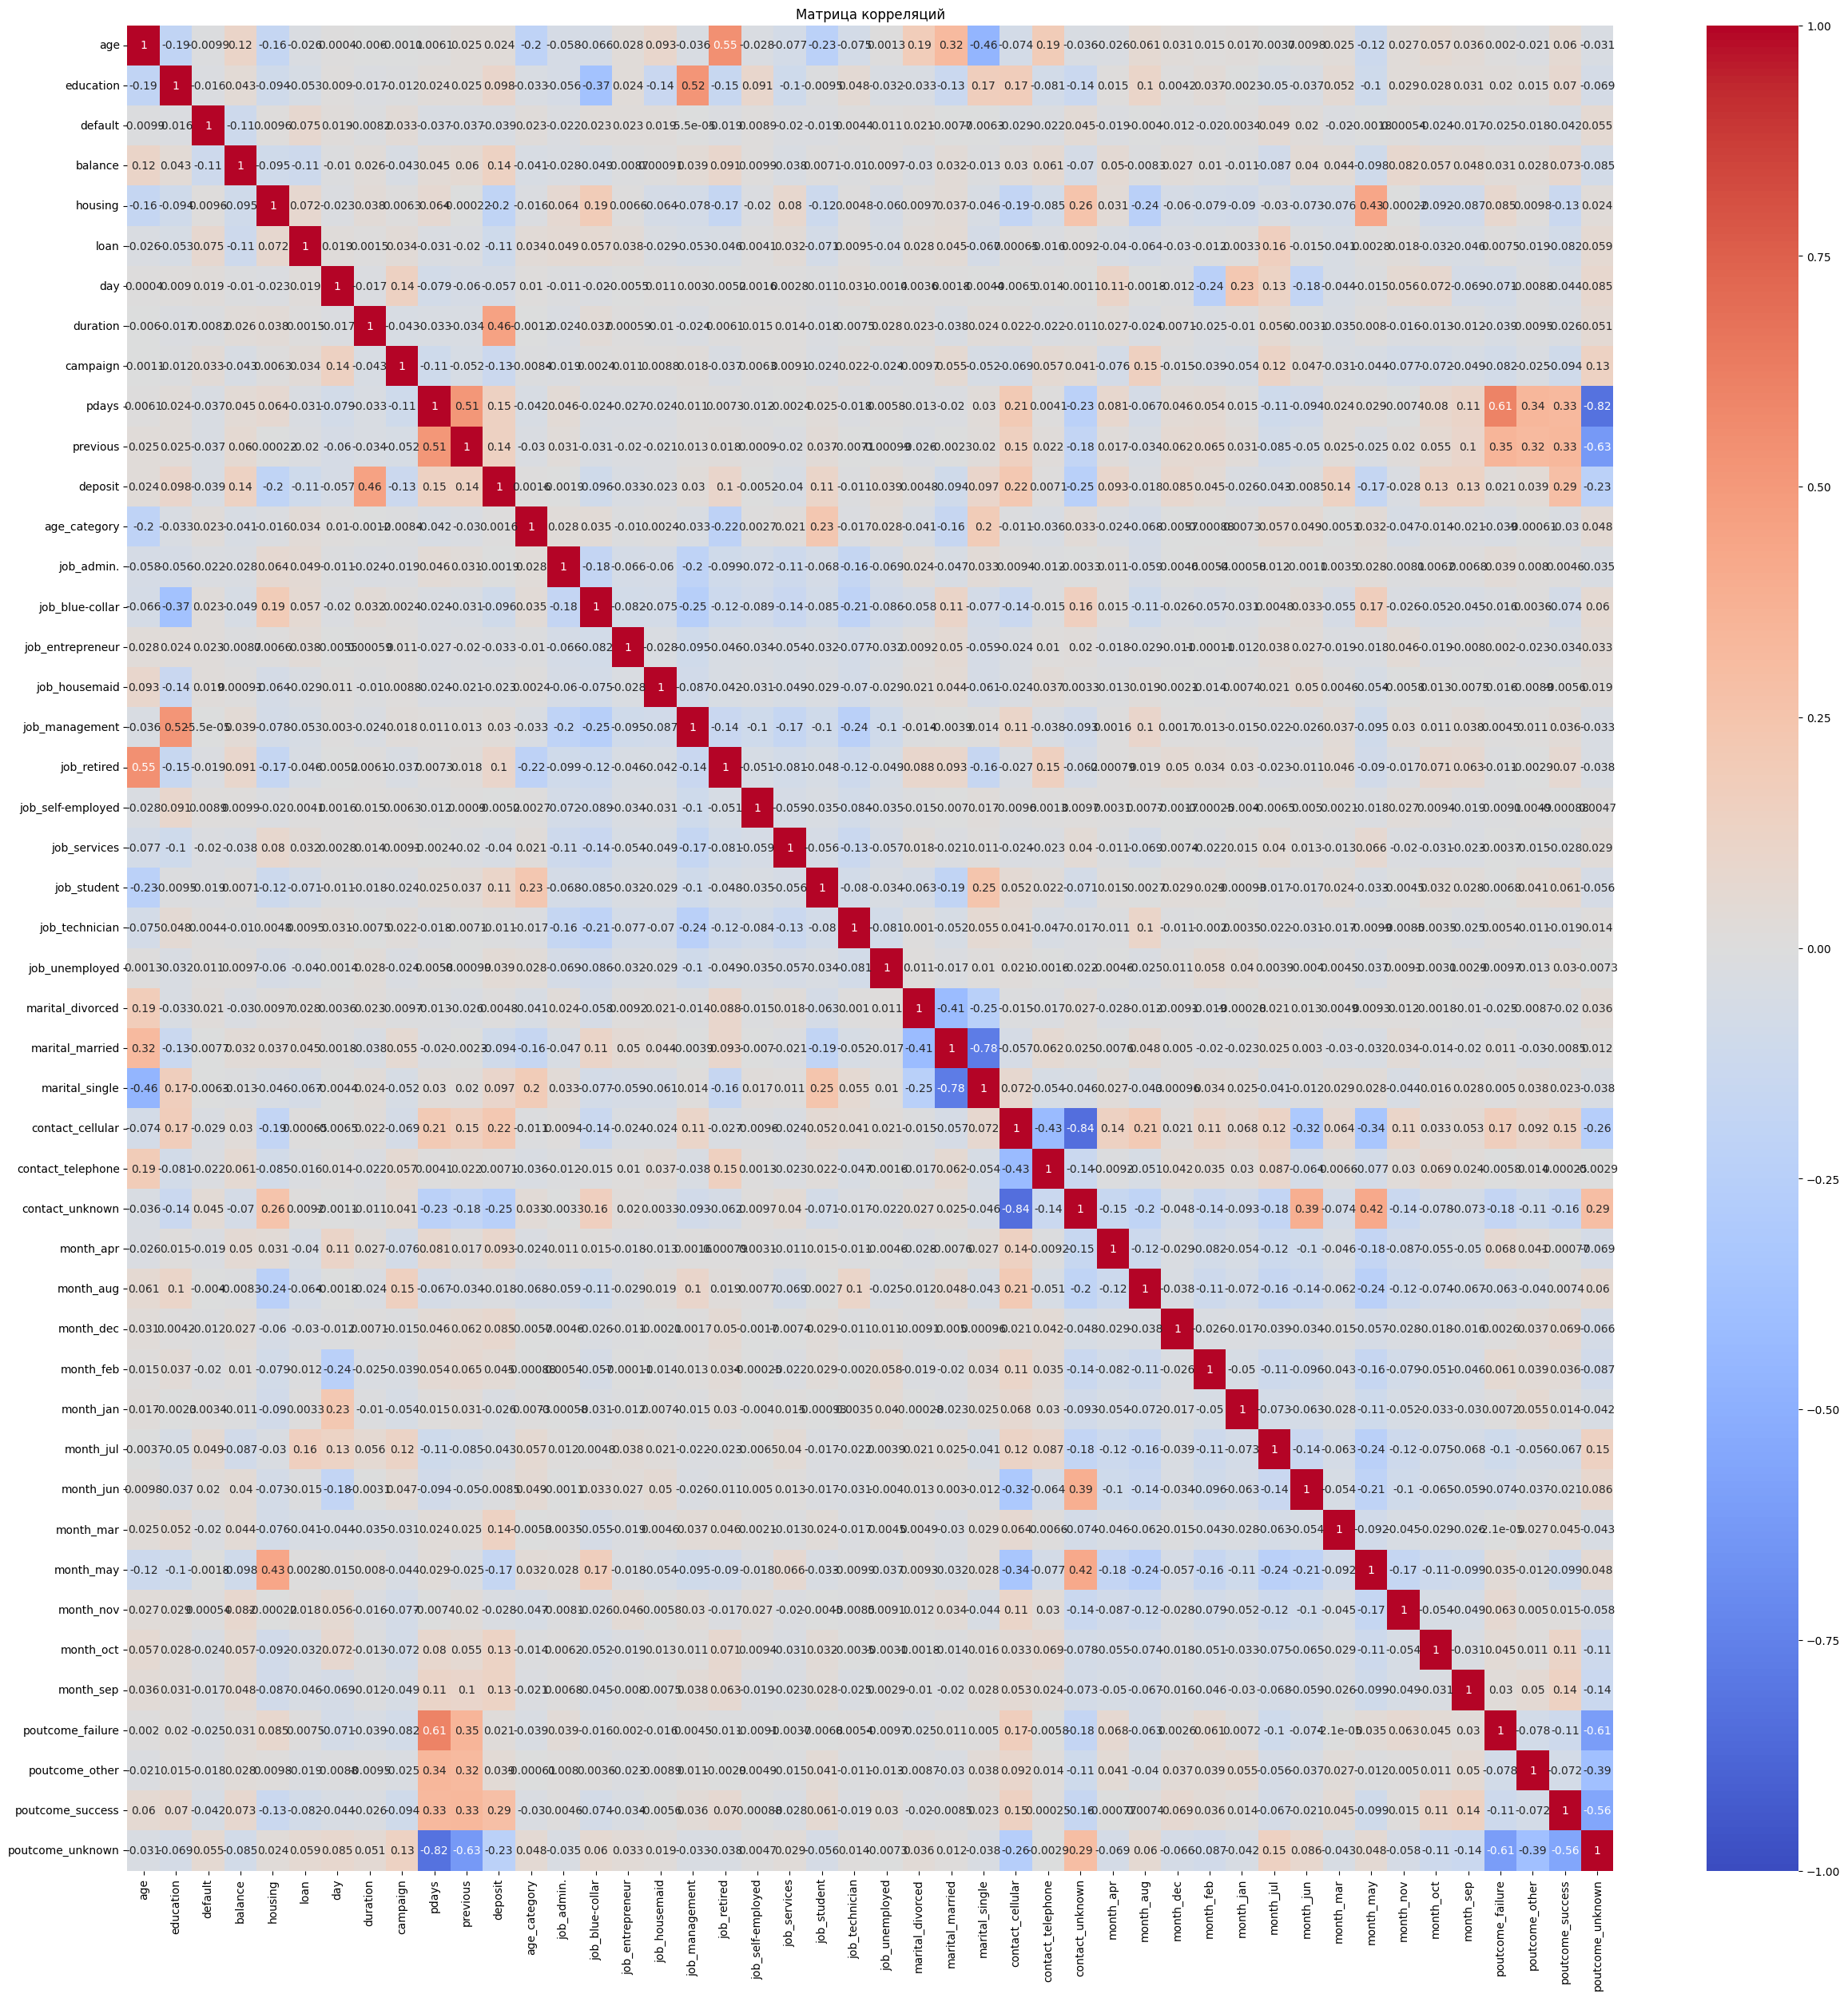

In [42]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

# вычисление матрицы корреляций
corr_matrix = df.corr()

# построение тепловой карты
plt.figure(figsize=(30,30)) 
sns.heatmap(df.corr(), annot=True,vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.title('Матрица корреляций')
plt.show()

Очень много признаков и матрицу корреляций неудобно анализировать, поэтому есть необходимость построить столбчатую диаграмму для ранжированных коэффициентов корреляции.

In [43]:
# вычислим коэффициенты корреляции с целевой переменной
corr_with_target = corr_matrix['deposit'].sort_values(ascending=False)[1:]

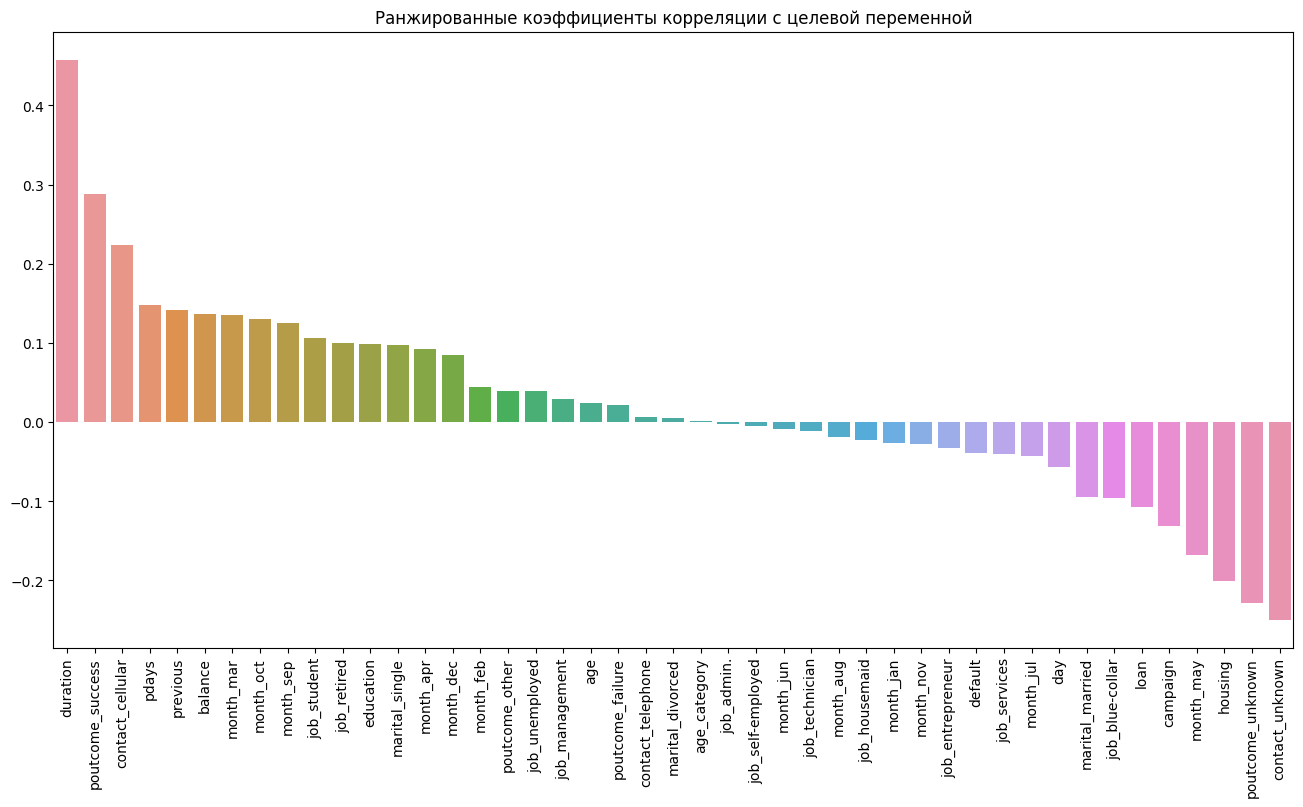

In [44]:
# построим столбчатую диаграмму
plt.figure(figsize=(16, 8))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
plt.xticks(rotation=90)
plt.title('Ранжированные коэффициенты корреляции с целевой переменной')
plt.show()

### Задания 7 и 8

In [45]:
df = df.drop(columns_for_get_dummies, axis=1)

In [46]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [47]:
# рассчитайте необходимые показатели
# Каким получился размер тестовой выборки?
X_test.shape

(3335, 45)

In [48]:
# Каково среднее значение целевой переменной на тестовой выборке?

round(y_test.mean(), 2)

0.46

### Задание 9

In [49]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train,y_train)

# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
Z_test = X_test.iloc[:,cols_idxs]

Z_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3335 entries, 3333 to 3818
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   balance           3335 non-null   float64
 1   housing           3335 non-null   int64  
 2   loan              3335 non-null   int64  
 3   duration          3335 non-null   int64  
 4   campaign          3335 non-null   int64  
 5   pdays             3335 non-null   int64  
 6   previous          3335 non-null   int64  
 7   contact_cellular  3335 non-null   uint8  
 8   contact_unknown   3335 non-null   uint8  
 9   month_mar         3335 non-null   uint8  
 10  month_may         3335 non-null   uint8  
 11  month_oct         3335 non-null   uint8  
 12  month_sep         3335 non-null   uint8  
 13  poutcome_success  3335 non-null   uint8  
 14  poutcome_unknown  3335 non-null   uint8  
dtypes: float64(1), int64(6), uint8(8)
memory usage: 234.5 KB


In [50]:
# Копируем названия столбцов
col_names = list(Z_test.columns)
# приведем выборки к одинаковоу числу признаков
Z_train = X_train[col_names]

### Задание 10

In [51]:
# нормализуйте данные с помощью minmaxsxaler

# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(Z_train)

# кодируем исходный датасет
X_train_mm = mm_scaler.transform(Z_train)
X_test_mm = mm_scaler.transform(Z_test)

In [52]:
# Рассчитайте среднее арифметическое для первого предиктора из тестовой выборки

print(round(X_test_mm[:, 0].mean(),2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [53]:
# обучите логистическую регрессию и рассчитайте метрики качества

lr = linear_model.LogisticRegression (solver='sag',
                                     random_state=42,
                                     max_iter=1000)
lr.fit(X_train_mm, y_train)
y_train_pred = lr.predict(X_train_mm)

print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = lr.predict(X_test_mm)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



У меня ответ не сходится с ответов на портале. Нужно 0.81

### Задания 2,3,4

In [54]:
# обучите решающие деревья, настройте максимальную глубину

#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений
dt_clf.fit(X_train_mm, y_train)

# сделаем предсказание на тренировочной выборке и выведем метрики 
y_train_pred = dt_clf.predict(X_train_mm)
print(metrics.classification_report(y_train, y_train_pred))

# сделаем предсказание на тестовой выборке и выведем метрики
y_test_pred = dt_clf.predict(X_test_mm)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1790
           1       0.73      0.74      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

In [55]:
# обучите решающие деревья, настройте максимальную глубину

#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=6,
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений
dt_clf.fit(X_train_mm, y_train)

# сделаем предсказание на тренировочной выборке и выведем метрики 
y_train_pred = dt_clf.predict(X_train_mm)
print(metrics.classification_report(y_train, y_train_pred))

# сделаем предсказание на тестовой выборке и выведем метрики
y_test_pred = dt_clf.predict(X_test_mm)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3634
           1       0.82      0.77      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.76      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



### Задание 5

Реализуйте оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:

* 'min_samples_split': [2, 5, 7, 10];
* 'max_depth':[3,5,7].

In [56]:
# подберите оптимальные параметры с помощью gridsearch

params = {'min_samples_split' : [2, 5, 7, 10],
          'max_depth' : [3, 5, 7]}
# вызовем класс GridSearchCV и передадим параметры
grid_search_dt = GridSearchCV(
    tree.DecisionTreeClassifier(),
    params,
    scoring='f1',
    cv=5,
    return_train_score=True
)

%time grid_search_dt.fit(X_train_mm, y_train)

#Выводим значения метрики 
y_train_pred = grid_search_dt.predict(X_train_mm)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = grid_search_dt.predict(X_test_mm)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_dt.best_params_))

CPU times: total: 766 ms
Wall time: 766 ms
f1_score на тренировочном наборе: 0.82
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Обучите случайный лес со следующими параметрами:

* n_estimators = 100;
* criterion = 'gini';
* min_samples_leaf = 5;
* max_depth = 10;
* random_state = 42.

### Задание 1

In [57]:
# обучите на ваших данных случайный лес

#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42)

# Обучаем модель
rf.fit(X_train_mm, y_train)

#Выводим значения метрики 
y_train_pred = rf.predict(X_train_mm)
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = rf.predict(X_test_mm)
print(metrics.classification_report(y_test, y_test_pred))

print('Test recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.86      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Test recall: 0.83


### Задания 2 и 3

Используйте градиентный бустинг для решения задачи классификации, задав для него следующие параметры:

* learning_rate = 0.05;
* n_estimators = 300;
* min_samples_leaf = 5;
* max_depth = 5;
* random_state = 42.

In [58]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом 0,82

# Создаем объект класса градиентный бустинг
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

# Обучаем модель
gb.fit(X_train_mm, y_train)

#Выводим значения метрики 
y_train_pred = gb.predict(X_train_mm)

print(metrics.classification_report(y_train, y_train_pred))
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = gb.predict(X_test_mm)
print(metrics.classification_report(y_test, y_test_pred))
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      3634
           1       0.85      0.89      0.87      3136

    accuracy                           0.88      6770
   macro avg       0.88      0.88      0.88      6770
weighted avg       0.88      0.88      0.88      6770

Train: 0.87
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335

Test: 0.81


### Задание 4

В этом задании вам необходимо использовать стекинг, объединив те алгоритмы, которые вы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используйте модель логистической регрессии.

Параметры оставьте те же, что были в ваших алгоритмах в предыдущих заданиях.

In [59]:
# объедините уже известные вам алгоритмы с помощью стекинга 

#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', linear_model.LogisticRegression(
        solver='sag', 
        random_state=42)),
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy', 
        min_samples_leaf=5, 
        max_depth=6, 
        random_state=42)),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate = 0.05, 
        n_estimators = 300, 
        min_samples_leaf = 5, 
        max_depth = 5, 
        random_state = 42))
    ]

# Создаем объект класса стекинг
reg = ensemble.StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=linear_model.LogisticRegression( # метамодель
        random_state=42 #датчик генератора случайных чисел
    )
)

# Обучаем модель
reg.fit(X_train_mm, y_train)

# Формируем предсказание, Выводим значения метрики 

y_train_pred = reg.predict(X_train_mm)
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = reg.predict(X_test_mm)
print(metrics.classification_report(y_test, y_test_pred))

print('F1 Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3634
           1       0.84      0.85      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

F1 Test: 0.81


### Задание 5

In [60]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

col_names

['balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

Feature: 0, Score: 0.06192
Feature: 1, Score: 0.05046
Feature: 2, Score: 0.01271
Feature: 3, Score: 0.51414
Feature: 4, Score: 0.01801
Feature: 5, Score: 0.05543
Feature: 6, Score: 0.00761
Feature: 7, Score: 0.00200
Feature: 8, Score: 0.07895
Feature: 9, Score: 0.02703
Feature: 10, Score: 0.01468
Feature: 11, Score: 0.01952
Feature: 12, Score: 0.01561
Feature: 13, Score: 0.11899
Feature: 14, Score: 0.00295


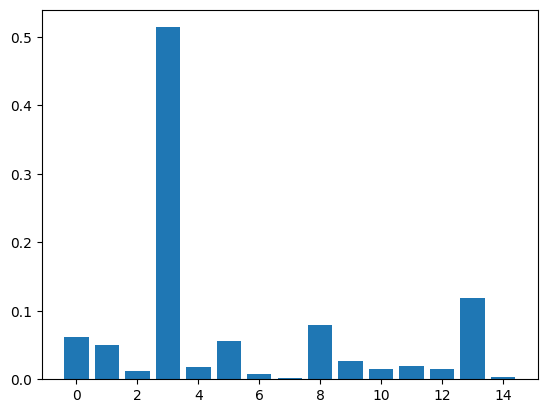

In [61]:
importance = gb.feature_importances_
for i,v in enumerate(importance):
  print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Задания 6,7,8

Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearch. Однако вы знаете, что это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. Примените его для оптимизации гиперпараметров. Для перебора возьмите случайный лес и следующие параметры:

n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
max_depth = trial.suggest_int('max_depth', 10, 30, 1);
min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

In [62]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

# создаем функцию
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
    # обучаем модель
    model.fit(X_train_mm, y_train)
  
    # применим cross validation с тем же количеством фолдов
    score = metrics.f1_score(y_train, model.predict(X_train_mm))

    return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_mm, y_train)

# выведем значения метрики
y_train_pred = model.predict(X_train_mm)
print(metrics.classification_report(y_train, y_train_pred))
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test_mm)
print(metrics.classification_report(y_train, y_train_pred))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2023-07-09 22:01:31,014] A new study created in memory with name: RandomForestClassifier
[I 2023-07-09 22:01:31,661] Trial 0 finished with value: 0.8446040918319537 and parameters: {'n_estimators': 125, 'max_depth': 28, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8446040918319537.
[I 2023-07-09 22:01:32,361] Trial 1 finished with value: 0.8461778471138847 and parameters: {'n_estimators': 133, 'max_depth': 30, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8461778471138847.
[I 2023-07-09 22:01:33,003] Trial 2 finished with value: 0.8648228713486638 and parameters: {'n_estimators': 113, 'max_depth': 16, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8648228713486638.
[I 2023-07-09 22:01:33,561] Trial 3 finished with value: 0.8461059190031154 and parameters: {'n_estimators': 108, 'max_depth': 19, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.8648228713486638.
[I 2023-07-09 22:01:34,488] Trial 4 finished with value: 0.8423845193508115 and parameters: {'n_

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3634
           1       0.91      0.93      0.92      3136

    accuracy                           0.93      6770
   macro avg       0.92      0.93      0.93      6770
weighted avg       0.93      0.93      0.93      6770

f1_score на обучающем наборе: 0.92
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3634
           1       0.91      0.93      0.92      3136

    accuracy                           0.93      6770
   macro avg       0.92      0.93      0.93      6770
weighted avg       0.93      0.93      0.93      6770

f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров {'n_estimators': 153, 'max_depth': 26, 'min_samples_leaf': 2}
